In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
from torchvision import datasets, transforms


In [4]:
from torchvision import datasets, transforms
from PIL import Image

# Transformations - convert to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Function to slice the center of the image
def slice_center(img, slice_size=(25, 25)):
    center_x = img.shape[1] // 2
    center_y = img.shape[2] // 2
    start_x = center_x - slice_size[0] // 2
    start_y = center_y - slice_size[1] // 2
    return img[:, start_x:start_x+slice_size[0], start_y:start_y+slice_size[1]]

# Preprocessing - Slice the center of the image
train_images = [slice_center(image.numpy()) for image, _ in train_dataset]
test_images = [slice_center(image.numpy()) for image, _ in test_dataset]

# Convert list of arrays to a single numpy array
train_images = np.stack(train_images)
test_images = np.stack(test_images)

# Save numpy arrays to files
np.save('data/mnist25_train.npy', train_images)
np.save('data/mnist25_test.npy', test_images)


### slice center 25*25

(60000, 1, 25, 25)
(10000, 1, 25, 25)


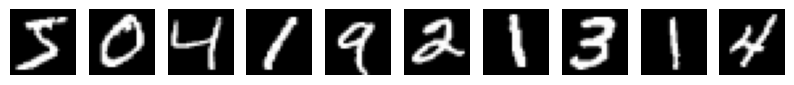

In [7]:
print(train_images.shape)
print(test_images.shape)
# plot 10 random images from the training set
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axes[i].imshow(train_images[i,0], cmap='gray')
    axes[i].axis('off')
plt.show()

(60000, 25, 5, 5)


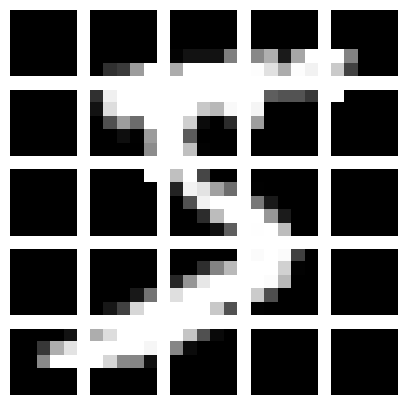

In [9]:
def slice_into_patches(image, patch_size=(5, 5)):
    # Extract the patches
    patches = []
    for i in range(0, image.shape[1], patch_size[0]):
        for j in range(0, image.shape[2], patch_size[1]):
            patch = image[:, i:i+patch_size[0], j:j+patch_size[1]]
            patches.append(patch)
    # Concatenate all patches along the channel dimension
    return np.concatenate(patches, axis=0)

# Preprocessing - Slice each image into 25 patches
train_images_patches = [slice_into_patches(image) for image in train_images]
test_images_patches = [slice_into_patches(image) for image in test_images]

# Convert list of arrays to a single numpy array
train_images_patches = np.stack(train_images_patches)
test_images_patches = np.stack(test_images_patches)

# print shape and plot 25 patches from the first image
print(train_images_patches.shape)
fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(train_images_patches[0, i*5+j], cmap='gray')
        axes[i, j].axis('off')
plt.show()

# save numpy arrays to files
np.save('data/mnist25_train_patches.npy', train_images_patches)
np.save('data/mnist25_test_patches.npy', test_images_patches)

### make dataloader

In [8]:
# load patches data from files
train_images_patches = np.load('data/mnist25_train_patches.npy')
test_images_patches = np.load('data/mnist25_test_patches.npy')

# get the label from datasets.MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)

# make them to be PyTorch tensors, and dataloader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_images_patches), train_labels)
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_images_patches), test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# test dataloader
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break


torch.Size([32, 25, 5, 5])
torch.Size([32])


### define model

In [9]:
# define a model
# define sub model first
class SubModel(nn.Module):
    def __init__(self):
        super(SubModel, self).__init__()
        self.fc0 = nn.Linear(13, 11, bias=False)
        self.fc1 = nn.Linear(11, 9, bias=False)
        self.fc2 = nn.Linear(9, 7, bias=False)
        self.fc3 = nn.Linear(7, 5, bias=False)
        self.fc4 = nn.Linear(5, 3, bias=False)
        self.fc5 = nn.Linear(3, 1, bias=False)
        # masks
        self.mask0 = self.generate_mask(13, 11)
        self.mask1 = self.generate_mask(11, 9)
        self.mask2 = self.generate_mask(9, 7)
        self.mask3 = self.generate_mask(7, 5)
        self.mask4 = self.generate_mask(5, 3)
        self.mask5 = self.generate_mask(3, 1)
        ##
        self.FC0 = nn.Linear(25, 10, bias=False)
        self.FC1 = nn.Linear(10, 1, bias=False)

        self.logg = False
    
    def generate_mask(self, in_dim, out_dim):
        assert (in_dim % 2 == 1) and (out_dim % 2 == 1) and (in_dim-out_dim==2), "in_dim and out_dim must be odd and in_dim-out_dim=2"
        mask = torch.zeros(out_dim, in_dim)
        for i in range(out_dim):
            if i % 2 == 0:  # For every second row
                start_index = i  # Determine start index for the 1's in this row
                mask[i, start_index:start_index+3] = 1
        
        return mask
    
    def forward(self, x):
        assert x.shape[1] == 25, "x.shape[1] must be 25, but got {}".format(x.shape[1])
        assert len(x.shape) == 2, "len(x.shape) must be 2, but got {}".format(len(x.shape))

        # self.fc0.weight.data *= self.mask0
        # x0 = self.fc0(x[:, 0:13]) # x0(b,11)
        # # insert x[:, 13:18] to x0[1], x0[3], x0[5], x0[7], x0[9]
        # x0c = torch.cat((x0[:, 0:1], x[:, 13:14], x0[:, 2:3], x[:, 14:15], x0[:, 4:5], x[:, 15:16], 
        #                  x0[:, 6:7], x[:, 16:17], x0[:, 8:9], x[:, 17:18], x0[:, 10:11]), dim=1)
        # x0c = torch.tanh(x0c)

        # self.fc1.weight.data *= self.mask1
        # x1 = self.fc1(x0c)
        # # insert x[:, 18:22] to x1[1], x1[3], x1[5], x1[7]
        # x1c = torch.cat((x1[:, 0:1], x[:, 18:19], x1[:, 2:3], x[:, 19:20], 
        #                  x1[:, 4:5], x[:, 20:21], x1[:, 6:7], x[:, 21:22], x1[:, 8:9]), dim=1)
        # x1c = torch.tanh(x1c)

        # self.fc2.weight.data *= self.mask2
        # x2 = self.fc2(x1c)
        # # insert x[:, 22:25] to x2[1], x2[3], x2[5]
        # x2c = torch.cat((x2[:, 0:1], x[:, 22:23], x2[:, 2:3], x[:, 23:24], x2[:, 4:5], x[:, 24:25], x2[:, 6:7]), dim=1)
        # x2c = torch.tanh(x2c)

        # self.fc3.weight.data *= self.mask3
        # x3 = self.fc3(x2c)
        # # no insert from now on(fc3)
        # x3 = torch.tanh(x3)

        # self.fc4.weight.data *= self.mask4
        # x4 = self.fc4(x3)
        # x4 = torch.tanh(x4)

        # self.fc5.weight.data *= self.mask5
        # x5 = self.fc5(x4)
        # x5 = torch.tanh(x5)


        # if self.logg: print(x0, x0c, '\n', x1, x1c, '\n',
        #                     x2, x2c, '\n', x3, '\n', x4, '\n', x5)

        x = self.FC0(x)
        x = torch.tanh(x)
        x = self.FC1(x)
        x = torch.tanh(x)

        return x

# test model use randn input
# model = SubModel()
# x = torch.randn(1, 25)
# model(x)

# define main model
# main model contain 25 sub models, and concat the 25 submodels' output to a 25-dim vector
# then use mainmodel(25,10) to process the 25-dim vector
class MainModel(nn.Module):
    def __init__(self) -> None:
        super(MainModel, self).__init__()
        self.submodels = nn.ModuleList([SubModel() for _ in range(25)])
        self.logg = False

        # self.fc0 = nn.Linear(23, 21, bias=False)
        # self.fc1 = nn.Linear(21, 19, bias=False)
        # self.fc2 = nn.Linear(19, 17, bias=False)
        # self.fc3 = nn.Linear(17, 15, bias=False)
        # self.fc4 = nn.Linear(15, 13, bias=False)
        # self.fc5 = nn.Linear(13, 11, bias=False)


        self.fcfc1 = nn.Linear(25, 20, bias=False)
        self.fcfc2 = nn.Linear(20, 10, bias=False)

        self.mask0 = self.generate_mask(23, 21)
        self.mask1 = self.generate_mask(21, 19)

    def generate_mask(self, in_dim, out_dim):
        assert (in_dim % 2 == 1) and (out_dim % 2 == 1) and (in_dim-out_dim==2), "in_dim and out_dim must be odd and in_dim-out_dim=2"
        mask = torch.zeros(out_dim, in_dim)
        half_input_dim = in_dim // 2
        for i in range(out_dim):
            if i % 2 == 0:  # For every second row
                start_index = i  # Determine start index for the 1's in this row
                mask[i, start_index:start_index+half_input_dim] = 1
        
        return mask
    
    def forward(self, xx):
        assert len(xx.shape) == 3, "Main. len(x.shape) must be 3, but got {}".format(len(xx.shape))
        assert (xx.shape[1]==25) and (xx.shape[2]==25), "Main. x.shape[1] and x.shape[2] must be 25, but got {} and {}".format(xx.shape[1], xx.shape[2])
        # the 25 input to 25 submodels
        sub_results = []
        for i in range(25):
            sub_results.append(self.submodels[i](xx[:, i, :]))
        
        sub_results = torch.cat(sub_results, dim=1)
        if self.logg: print('sub_results:',sub_results.shape) # (b, 25)

        # directly use fcfc to process the 25-dim vector
        x1c = self.fcfc1(sub_results)
        x1c = torch.tanh(x1c)
        x2 = self.fcfc2(x1c)
        x2c = torch.tanh(x2)

        # # process the 25-dim vector
        # # self.fc0.weight.data *= self.mask0
        # x0 = self.fc0(sub_results[:, 0:23])
        # x0c = torch.cat((x0[:, 0:9], sub_results[:, 23:24], x0[:, 10:11], sub_results[:, 24:25], x0[:, 12:21]), dim=1)
        # x0c = torch.tanh(x0c)

        # # self.fc1.weight.data *= self.mask1
        # x1 = self.fc1(x0c)
        # x1 = torch.tanh(x1) # (b, 19)

        # # select the 10-dim vector from the 19-dim vector
        # # select 0, 2, 4, 6, 8, 10, 12, 14, 16, 18
        # x1c = torch.cat((x1[:, 0:1], x1[:, 2:3], x1[:, 4:5], x1[:, 6:7], x1[:, 8:9],
        #                     x1[:, 10:11], x1[:, 12:13], x1[:, 14:15], x1[:, 16:17], x1[:, 18:19]), dim=1)
        # x1c = torch.tanh(x1c)


        return x2c

# use randn input to test main model
# model = MainModel()
# x = torch.randn(1, 25, 25)
# model(x) # (1, 10)

# train the model ********************************************************
model = MainModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train
model.train()
max_acc, min_loss = 0, 100
for epoch in range(60):
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.view(-1, 25, 25)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))

    # test model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.view(-1, 25, 25)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # save best model, both accuracy and loss
        if correct/total > max_acc and loss.item() < min_loss:
            max_acc = correct/total
            min_loss = loss.item()
            #torch.save(model.state_dict(), 'data/patch_mnist.pth')
            print('saved at epoch {}, acc {}, loss {}'.format(epoch, max_acc, min_loss))
        

epoch 0, loss 1.0738197565078735
saved at epoch 0, acc 0.8682, loss 1.0098844766616821
epoch 1, loss 0.9690185785293579
saved at epoch 1, acc 0.8996, loss 0.9074183702468872
epoch 2, loss 0.9214884638786316
saved at epoch 2, acc 0.9102, loss 0.8890491127967834
epoch 3, loss 0.9970874190330505
saved at epoch 3, acc 0.9183, loss 0.85861736536026
epoch 4, loss 1.003183126449585
epoch 5, loss 0.9366672039031982
saved at epoch 5, acc 0.9253, loss 0.8410511016845703
epoch 6, loss 1.0237972736358643
epoch 7, loss 1.0060409307479858
epoch 8, loss 0.8665066957473755
saved at epoch 8, acc 0.9349, loss 0.8322146534919739
epoch 9, loss 1.050097942352295
saved at epoch 9, acc 0.9383, loss 0.8292393684387207
epoch 10, loss 0.8975090980529785
saved at epoch 10, acc 0.9409, loss 0.828284740447998
epoch 11, loss 0.8896580934524536
epoch 12, loss 1.0821293592453003
saved at epoch 12, acc 0.9424, loss 0.8272802233695984
epoch 13, loss 0.8127976655960083
epoch 14, loss 0.9229679703712463
saved at epoch 14

In [12]:
import numpy as np

def generate_mask(input_dim, output_dim):
    mask = np.zeros((output_dim, input_dim))  # Create an array of zeros

    half_input_dim = input_dim // 2  # Half of the input dimension (rounded down)

    for i in range(output_dim):
        if i % 2 == 0:  # For every second row
            start_index = i  # Determine start index for the 1's in this row
            mask[i, start_index:start_index+half_input_dim] = 1

    return mask

# Test the function with linear(7,5)
mask = generate_mask(7, 5)
print(mask)


[[1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1.]]
